In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from time import time
import itertools
import warnings
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [3]:
df = pd.read_csv(
    r"C:\Users\Nguyên\OneDrive\Desktop\Portfolio project\sales_tbl.csv",
    parse_dates=["orderdate"],
    index_col="orderdate"
)
df.head()

,orderkey,linenumber,deliverydate,customerkey,storekey,productkey,quantity,unitprice,netprice,unitcost,currencycode,exchangerate,currentstock
orderdate,,,,,,,,,,,,,
2015-01-13,13005,0,1/13/2015,390139,90,147,3,2319.992,2134.39264,768.656,CAD,1.19657,801
2015-01-14,14000,1,1/14/2015,1185065,420,1904,2,674.250,674.25000,310.065,GBP,0.65843,800
2015-01-14,14002,1,1/14/2015,708902,280,2095,2,1106.250,1050.93750,366.525,EUR,0.84926,799
2015-01-14,14003,0,1/14/2015,591175,220,1660,2,173.994,173.99400,57.648,EUR,0.84926,800
2015-01-14,14003,2,1/14/2015,591175,220,1236,1,300.800,258.68800,153.360,EUR,0.84926,802


In [4]:
df["demand"] = df["unitprice"] * df["quantity"]

df_demand = df[["demand"]].copy()
df_demand["orderdate"] = df_demand.index

df_demand = df_demand[["orderdate", "demand"]]

print(df_demand.head())

            orderdate    demand
orderdate                      
2015-01-13 2015-01-13  6959.976
2015-01-14 2015-01-14  1348.500
2015-01-14 2015-01-14  2212.500
2015-01-14 2015-01-14   347.988
2015-01-14 2015-01-14   300.800


In [5]:
df_demand = df_demand.resample("MS")["demand"].sum()  # MS = Month Start

In [6]:
def plot_co2(train, test, y_pred, title):
    plt.figure(figsize=(10,4))
    mae = mean_absolute_error(test, y_pred)
    train["2016":].plot(legend=True, label="TRAIN", title=f"{title}")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()

In [7]:
train = df_demand[:'2024-03-01']
test = df_demand['2023-06-01':]

In [8]:
tes_model = ExponentialSmoothing(train,
                                 trend="add", # add || mul
                                 seasonal="add", # add || mul
                                 seasonal_periods=12 # we set 12. It represents that 12 step (month for our case) equals a seasonal period
                                 ).fit(smoothing_level=0.5, # alpha
                                        smoothing_trend=0.5, # beta
                                        smoothing_seasonal=0.5 # gamma
                                        )

In [9]:
y_pred = tes_model.forecast(11)

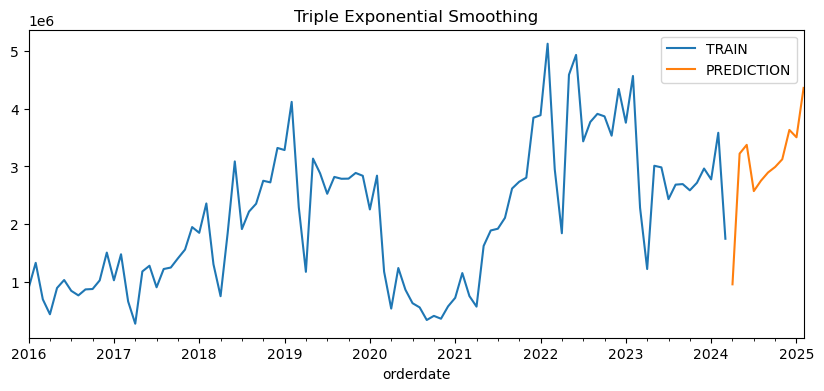

In [10]:
plot_co2(train, test, y_pred, "Triple Exponential Smoothing")

In [11]:
def tes_optimizer(train, test, abg, trend_mode='add', seasonal_mode = 'add', seasonal_period=12,step=11):
    """This function to optimize hyperparameters for the TES model

    Args:
        train (pd.Series): train dataset
        test (pd.Series): test dataset
        abg (list): a tuple list that holds tuple of alpha, beta, gamma values
        trend_mode (str, optional): 'add' || 'mul' . Is the trend additive or multiplying? Defaults to 'add'.
        seasonal_mode (str, optional): 'add' || 'mul' . Is the seasonality additive or multiplying?. Defaults to 'add'.
        seasonal_period (int, optional): Step number that evaluates for the seasonal period. Defaults to 12.
        step (int, optional): How many steps later will the model that created with the train dataset forecast?. Defaults to 48.

    Returns:
        [float, float, float, float]: best_alpha, best_beta, best_gamma, best_mae
    """
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")

    for comb in abg: # visit the each combination
        tes_model = ExponentialSmoothing(train, trend=trend_mode, seasonal=seasonal_mode, seasonal_periods=seasonal_period).\
            fit(smoothing_level=comb[0], smoothing_trend=comb[1], smoothing_seasonal=comb[2]) # 0: alpha, 1: beta, 2: gamma. Creates a new TES instance by using each combination
        y_pred = tes_model.forecast(step) # forecast the `step` step later by using the TES instance
        mae = mean_absolute_error(test, y_pred) # calculate the MAE (mean absolute error)
        if mae < best_mae: # mark the best parameters
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

In [12]:
alphas = betas = gammas = np.arange(0.10, 1, 0.20)

In [13]:
print("Alphas: {}\nBetas: {}\nGammas: {}".format(alphas, betas, gammas))

Alphas: [0.1 0.3 0.5 0.7 0.9]
Betas: [0.1 0.3 0.5 0.7 0.9]
Gammas: [0.1 0.3 0.5 0.7 0.9]


In [14]:
abg = list(itertools.product(alphas, betas, gammas))

In [15]:
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train,test, abg)

[np.float64(0.1), np.float64(0.1), np.float64(0.1), 695575.08]
[np.float64(0.1), np.float64(0.1), np.float64(0.3), 744985.07]
[np.float64(0.1), np.float64(0.1), np.float64(0.5), 835471.46]
[np.float64(0.1), np.float64(0.1), np.float64(0.7), 874796.99]


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[np.float64(0.1), np.float64(0.1), np.float64(0.9), 918605.31]
[np.float64(0.1), np.float64(0.3), np.float64(0.1), 1913438.5]
[np.float64(0.1), np.float64(0.3), np.float64(0.3), 1635929.22]
[np.float64(0.1), np.float64(0.3), np.float64(0.5), 1333217.37]
[np.float64(0.1), np.float64(0.3), np.float64(0.7), 1141074.51]
[np.float64(0.1), np.float64(0.3), np.float64(0.9), 1073544.75]
[np.float64(0.1), np.float64(0.5), np.float64(0.1), 929127.34]
[np.float64(0.1), np.float64(0.5), np.float64(0.3), 809790.98]
[np.float64(0.1), np.float64(0.5), np.float64(0.5), 786110.51]
[np.float64(0.1), np.float64(0.5), np.float64(0.7), 886980.14]
[np.float64(0.1), np.float64(0.5), np.float64(0.9), 1265360.19]
[np.float64(0.1), np.float64(0.7), np.float64(0.1), 881705.76]
[np.float64(0.1), np.float64(0.7), np.float64(0.3), 788724.62]
[np.float64(0.1), np.float64(0.7), np.float64(0.5), 774998.97]
[np.float64(0.1), np.float64(0.7), np.float64(0.7), 1072159.77]
[np.float64(0.1), np.float64(0.7), np.float64(0.9

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[np.float64(0.3), np.float64(0.1), np.float64(0.5), 875657.96]
[np.float64(0.3), np.float64(0.1), np.float64(0.7), 821589.93]
[np.float64(0.3), np.float64(0.1), np.float64(0.9), 772921.17]
[np.float64(0.3), np.float64(0.3), np.float64(0.1), 728558.75]


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[np.float64(0.3), np.float64(0.3), np.float64(0.3), 822395.46]
[np.float64(0.3), np.float64(0.3), np.float64(0.5), 862532.32]
[np.float64(0.3), np.float64(0.3), np.float64(0.7), 825932.0]
[np.float64(0.3), np.float64(0.3), np.float64(0.9), 886671.53]


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[np.float64(0.3), np.float64(0.5), np.float64(0.1), 702741.19]
[np.float64(0.3), np.float64(0.5), np.float64(0.3), 857943.33]
[np.float64(0.3), np.float64(0.5), np.float64(0.5), 925227.07]
[np.float64(0.3), np.float64(0.5), np.float64(0.7), 843773.08]


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[np.float64(0.3), np.float64(0.5), np.float64(0.9), 814166.22]
[np.float64(0.3), np.float64(0.7), np.float64(0.1), 749903.14]
[np.float64(0.3), np.float64(0.7), np.float64(0.3), 860144.18]
[np.float64(0.3), np.float64(0.7), np.float64(0.5), 896726.46]
[np.float64(0.3), np.float64(0.7), np.float64(0.7), 884965.38]
[np.float64(0.3), np.float64(0.7), np.float64(0.9), 1105439.59]
[np.float64(0.3), np.float64(0.9), np.float64(0.1), 828421.22]
[np.float64(0.3), np.float64(0.9), np.float64(0.3), 829979.24]
[np.float64(0.3), np.float64(0.9), np.float64(0.5), 836156.11]


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[np.float64(0.3), np.float64(0.9), np.float64(0.7), 890716.79]
[np.float64(0.3), np.float64(0.9), np.float64(0.9), 1502874.71]
[np.float64(0.5), np.float64(0.1), np.float64(0.1), 780045.11]
[np.float64(0.5), np.float64(0.1), np.float64(0.3), 830002.39]


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[np.float64(0.5), np.float64(0.1), np.float64(0.5), 895547.71]
[np.float64(0.5), np.float64(0.1), np.float64(0.7), 934684.45]
[np.float64(0.5), np.float64(0.1), np.float64(0.9), 934246.08]
[np.float64(0.5), np.float64(0.3), np.float64(0.1), 758795.44]
[np.float64(0.5), np.float64(0.3), np.float64(0.3), 801391.21]


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[np.float64(0.5), np.float64(0.3), np.float64(0.5), 874677.31]
[np.float64(0.5), np.float64(0.3), np.float64(0.7), 898983.06]
[np.float64(0.5), np.float64(0.3), np.float64(0.9), 998216.13]
[np.float64(0.5), np.float64(0.5), np.float64(0.1), 779228.9]
[np.float64(0.5), np.float64(0.5), np.float64(0.3), 773618.85]
[np.float64(0.5), np.float64(0.5), np.float64(0.5), 902460.8]


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[np.float64(0.5), np.float64(0.5), np.float64(0.7), 1549004.14]
[np.float64(0.5), np.float64(0.5), np.float64(0.9), 1140762.15]
[np.float64(0.5), np.float64(0.7), np.float64(0.1), 786262.66]
[np.float64(0.5), np.float64(0.7), np.float64(0.3), 844071.98]
[np.float64(0.5), np.float64(0.7), np.float64(0.5), 1366453.58]
[np.float64(0.5), np.float64(0.7), np.float64(0.7), 2057999.86]
[np.float64(0.5), np.float64(0.7), np.float64(0.9), 1090516.14]


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[np.float64(0.5), np.float64(0.9), np.float64(0.1), 781604.04]
[np.float64(0.5), np.float64(0.9), np.float64(0.3), 1000941.44]
[np.float64(0.5), np.float64(0.9), np.float64(0.5), 1465671.67]
[np.float64(0.5), np.float64(0.9), np.float64(0.7), 1372630.89]
[np.float64(0.5), np.float64(0.9), np.float64(0.9), 1832158.7]
[np.float64(0.7), np.float64(0.1), np.float64(0.1), 813808.23]


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[np.float64(0.7), np.float64(0.1), np.float64(0.3), 805345.16]
[np.float64(0.7), np.float64(0.1), np.float64(0.5), 854405.7]
[np.float64(0.7), np.float64(0.1), np.float64(0.7), 923056.96]
[np.float64(0.7), np.float64(0.1), np.float64(0.9), 1047938.06]
[np.float64(0.7), np.float64(0.3), np.float64(0.1), 790398.38]


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[np.float64(0.7), np.float64(0.3), np.float64(0.3), 783638.13]
[np.float64(0.7), np.float64(0.3), np.float64(0.5), 855080.18]
[np.float64(0.7), np.float64(0.3), np.float64(0.7), 1051945.95]
[np.float64(0.7), np.float64(0.3), np.float64(0.9), 1153287.04]


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[np.float64(0.7), np.float64(0.5), np.float64(0.1), 777613.12]
[np.float64(0.7), np.float64(0.5), np.float64(0.3), 870222.54]
[np.float64(0.7), np.float64(0.5), np.float64(0.5), 1136525.96]
[np.float64(0.7), np.float64(0.5), np.float64(0.7), 1619622.31]
[np.float64(0.7), np.float64(0.5), np.float64(0.9), 1119762.52]
[np.float64(0.7), np.float64(0.7), np.float64(0.1), 795853.78]
[np.float64(0.7), np.float64(0.7), np.float64(0.3), 1168872.37]
[np.float64(0.7), np.float64(0.7), np.float64(0.5), 1947974.1]
[np.float64(0.7), np.float64(0.7), np.float64(0.7), 2442185.01]
[np.float64(0.7), np.float64(0.7), np.float64(0.9), 1361718.92]
[np.float64(0.7), np.float64(0.9), np.float64(0.1), 883701.86]
[np.float64(0.7), np.float64(0.9), np.float64(0.3), 1446060.47]


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[np.float64(0.7), np.float64(0.9), np.float64(0.5), 3339317.91]
[np.float64(0.7), np.float64(0.9), np.float64(0.7), 2291328.21]
[np.float64(0.7), np.float64(0.9), np.float64(0.9), 1530808.11]
[np.float64(0.9), np.float64(0.1), np.float64(0.1), 820074.87]
[np.float64(0.9), np.float64(0.1), np.float64(0.3), 799223.26]


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[np.float64(0.9), np.float64(0.1), np.float64(0.5), 839575.14]
[np.float64(0.9), np.float64(0.1), np.float64(0.7), 1022137.74]
[np.float64(0.9), np.float64(0.1), np.float64(0.9), 1203433.55]
[np.float64(0.9), np.float64(0.3), np.float64(0.1), 792884.87]
[np.float64(0.9), np.float64(0.3), np.float64(0.3), 835147.94]


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[np.float64(0.9), np.float64(0.3), np.float64(0.5), 1061273.61]
[np.float64(0.9), np.float64(0.3), np.float64(0.7), 1496387.96]
[np.float64(0.9), np.float64(0.3), np.float64(0.9), 1287845.48]
[np.float64(0.9), np.float64(0.5), np.float64(0.1), 833107.12]


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[np.float64(0.9), np.float64(0.5), np.float64(0.3), 1149442.5]
[np.float64(0.9), np.float64(0.5), np.float64(0.5), 1749808.16]
[np.float64(0.9), np.float64(0.5), np.float64(0.7), 1752241.33]
[np.float64(0.9), np.float64(0.5), np.float64(0.9), 1195764.05]
[np.float64(0.9), np.float64(0.7), np.float64(0.1), 905958.52]
[np.float64(0.9), np.float64(0.7), np.float64(0.3), 1203208.87]


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[np.float64(0.9), np.float64(0.7), np.float64(0.5), 1863027.36]
[np.float64(0.9), np.float64(0.7), np.float64(0.7), 1187723.44]
[np.float64(0.9), np.float64(0.7), np.float64(0.9), 1074387.16]
[np.float64(0.9), np.float64(0.9), np.float64(0.1), 903277.25]


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[np.float64(0.9), np.float64(0.9), np.float64(0.3), 1506924.86]
[np.float64(0.9), np.float64(0.9), np.float64(0.5), 1651265.36]
[np.float64(0.9), np.float64(0.9), np.float64(0.7), 1114276.25]
[np.float64(0.9), np.float64(0.9), np.float64(0.9), 1225325.18]
best_alpha: 0.1 best_beta: 0.1 best_gamma: 0.1 best_mae: 695575.0834


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [16]:
final_tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_trend=best_beta, smoothing_seasonal=best_gamma) # Creating the final tes model by using the best hyperparameters

y_pred = final_tes_model.forecast(11)

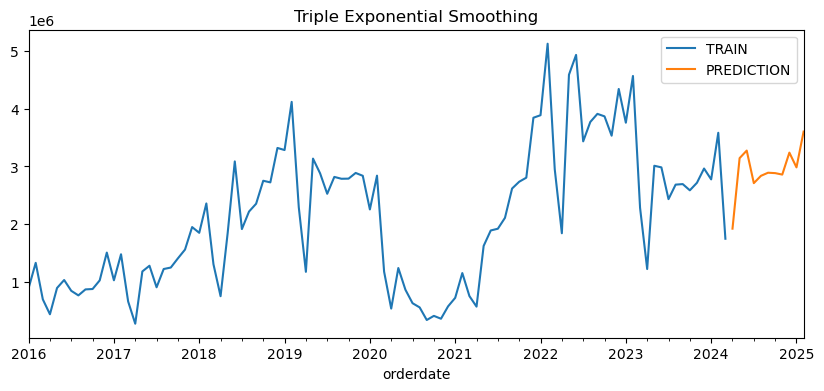

In [17]:
plot_co2(train, test, y_pred, "Triple Exponential Smoothing")

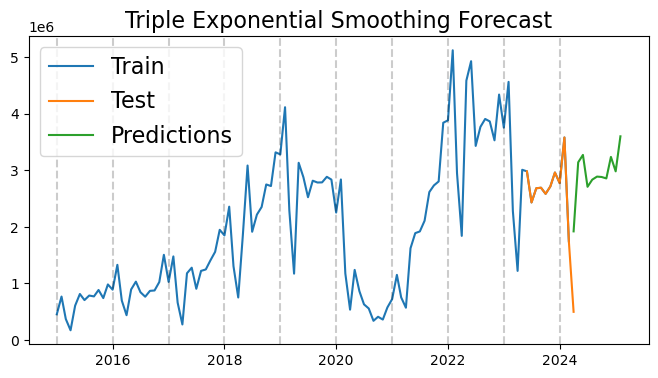

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

start_date = train.index.min()
end_date = test.index.max()

plt.figure(figsize=(8,4))

plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(y_pred, label="Predictions")

plt.legend(fontsize=16)
plt.title('Triple Exponential Smoothing Forecast', fontsize=16)
plt.ylabel('', fontsize=16)

for year in range(start_date.year, end_date.year + 1):
    plt.axvline(pd.to_datetime(f"{year}-01-01"), color='k', linestyle='--', alpha=0.2)

plt.show()
